<a href="https://colab.research.google.com/github/bilgindemir/ecg-cnn-incart/blob/main/CNNproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.2 MB/s eta 0:00:00


In [ ]:
import os

# Define base path
base_path = "/content/st_petersburg_cnn_project"

# Define folder structure
folders = ["data", "scripts", "models", "results"]

# Create folders
for folder in folders:
    os.makedirs(os.path.join(base_path, folder), exist_ok=True)

print("Project folder structure created!")


Project folder structure created!


In [ ]:
%%writefile /content/st_petersburg_cnn_project/scripts/data_loader.py

import wfdb
import numpy as np

def load_data(record_name, data_path):
    """
    Load ECG data and annotations from a given record.
    Args:
        record_name (str): The record name (e.g., 'I01').
        data_path (str): Path to the folder containing the INCART database.
    Returns:
        tuple: ECG signals (numpy array) and labels (annotations).
    """
    record_path = f"{data_path}/{record_name}"
    record = wfdb.rdrecord(record_path)
    annotations = wfdb.rdann(record_path, 'atr')
    signals = record.p_signal  # ECG signals
    labels = annotations.symbol  # Annotations
    return signals, labels

def preprocess_data(signals):
    """
    Normalize ECG signals.
    Args:
        signals (numpy array): Raw ECG signals.
    Returns:
        numpy array: Normalized ECG signals.
    """
    return (signals - np.min(signals)) / (np.max(signals) - np.min(signals))


Writing /content/st_petersburg_cnn_project/scripts/data_loader.py


In [ ]:
%%writefile /content/st_petersburg_cnn_project/scripts/cnn_model.py

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

def create_cnn(input_shape):
    """
    Define a 1D CNN model for ECG classification.
    Args:
        input_shape (tuple): Shape of the input data (timesteps, features).
    Returns:
        keras.Model: Compiled CNN model.
    """
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


Writing /content/st_petersburg_cnn_project/scripts/cnn_model.py


In [ ]:
# Import necessary functions
import sys
sys.path.append('/content/st_petersburg_cnn_project/scripts')

from data_loader import load_data, preprocess_data
from cnn_model import create_cnn

# Load a sample record
record_name = "I01"
data_path = "/content/st_petersburg_cnn_project/data"
signals, labels = load_data(record_name, data_path)
signals = preprocess_data(signals)

# Print shapes
print(f"Signals shape: {signals.shape}, Labels: {len(labels)}")

# Create a model
model = create_cnn((signals.shape[1], 1))
model.summary()


Signals shape: (462600, 12), Labels: 2757


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 10, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 5, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,865 (81.50 KB)

 Trainable params: 20,865 (81.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input

def create_cnn(input_shape):
    """
    Define a 1D CNN model for ECG classification.

    Args:
        input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
        keras.Model: Compiled CNN model.
    """
    model = Sequential([
        Input(shape=input_shape),  # Explicitly define input shape
        Conv1D(32, kernel_size=3, activation='relu'),  # First convolutional layer
        MaxPooling1D(pool_size=2),  # Max pooling layer
        Flatten(),  # Flatten the output for the dense layers
        Dense(128, activation='relu'),  # Fully connected layer
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    # Compile the model with binary cross-entropy loss and Adam optimizer
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
%%writefile /content/st_petersburg_cnn_project/scripts/train_model.py

import numpy as np
from sklearn.model_selection import train_test_split
from data_loader import load_data, preprocess_data
from cnn_model import create_cnn

def train_model(data_path, record_name, model_save_path):
    # Load and preprocess data
    signals, labels = load_data(record_name, data_path)
    signals = preprocess_data(signals)

    # Segment data into fixed-length chunks
    def segment_data(signals, segment_length=1000):
        X = []
        for i in range(0, len(signals) - segment_length, segment_length):
            X.append(signals[i:i+segment_length])
        return np.array(X)

    X = segment_data(signals)
    y = np.random.randint(0, 2, len(X))  # Placeholder labels (adjust this for real labels)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train CNN model
    model = create_cnn((X.shape[1], X.shape[2]))
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

    # Save model
    model.save(model_save_path)
    print(f"Model saved at {model_save_path}")


Overwriting /content/st_petersburg_cnn_project/scripts/train_model.py


In [ ]:
import numpy as np

def segment_data(signals, segment_length=1000):
    """
    Segment ECG signals into fixed-length chunks.
    Args:
        signals (numpy array): The ECG signals.
        segment_length (int): Length of each segment.
    Returns:
        numpy array: Segmented signals.
    """
    X = []
    for i in range(0, len(signals) - segment_length, segment_length):
        X.append(signals[i:i+segment_length])
    return np.array(X)

# Segment signals
segment_length = 1000
X = segment_data(signals, segment_length)

# Add a dummy label array for demonstration
y = np.random.randint(0, 2, len(X))  # Replace with actual labels for real data
print(f"Segmented Data Shape: {X.shape}, Labels Shape: {y.shape}")


Segmented Data Shape: (462, 1000, 12), Labels Shape: (462,)


In [ ]:
!pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.2 MB/s eta 0:00:00


In [ ]:
import numpy as np  # Ensure numpy is imported

def segment_data(signals, segment_length=1000):
    """
    Segment ECG signals into fixed-length chunks.
    Args:
        signals (numpy array): The ECG signals.
        segment_length (int): Length of each segment.
    Returns:
        numpy array: Segmented signals.
    """
    X = []
    for i in range(0, len(signals) - segment_length, segment_length):
        X.append(signals[i:i+segment_length])
    return np.array(X)

# Segment signals
segment_length = 1000
X = segment_data(signals, segment_length)

# Add a dummy label array for demonstration
y = np.random.randint(0, 2, len(X))  # Replace with actual labels for real data
print(f"Segmented Data Shape: {X.shape}, Labels Shape: {y.shape}")


Segmented Data Shape: (462, 1000, 12), Labels Shape: (462,)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the segmented data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}, Testing Data Shape: {X_test.shape}")


Training Data Shape: (369, 1000, 12), Testing Data Shape: (93, 1000, 12)


In [ ]:
from cnn_model import create_cnn

# Define the input shape based on segmented data
input_shape = (segment_length, X_train.shape[2])  # (timesteps, features)
model = create_cnn(input_shape)

# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 998, 32)             │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 499, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 15968)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       2,044,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,045,345 (7.80 MB)

 Trainable params: 2,045,345 (7.80 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
!ls /content/st_petersburg_cnn_project/scripts


cnn_model.py  data_loader.py  __pycache__  train_model.py


In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,               # Number of training epochs
    batch_size=32,           # Number of samples per batch
    validation_data=(X_test, y_test)  # Use testing data for validation
)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.5260 - loss: 1.9756 - val_accuracy: 0.4194 - val_loss: 0.7142
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4756 - loss: 0.7060 - val_accuracy: 0.4624 - val_loss: 0.6949
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5037 - loss: 0.6985 - val_accuracy: 0.4194 - val_loss: 0.7025
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5231 - loss: 0.6916 - val_accuracy: 0.4194 - val_loss: 0.6985
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.4606 - loss: 0.6962 - val_accuracy: 0.4194 - val_loss: 0.6949
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4987 - loss: 0.6931 - val_accuracy: 0.4194 - val_loss: 0.6938
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.4496 - loss: 0.6935 - val_accuracy: 0.5269 - val_loss: 0.6932
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5457 - loss: 0.6930 - val_accuracy: 0.5376 - v

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5510 - loss: 0.6928
Test Loss: 0.6930
Test Accuracy: 51.61%


In [ ]:
# Save the model
model.save("/content/st_petersburg_cnn_project/models/cnn_model.h5")
print("Model saved successfully!")


Model saved successfully!


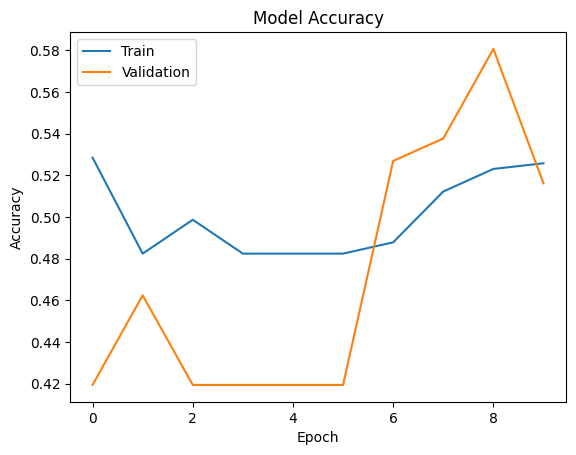

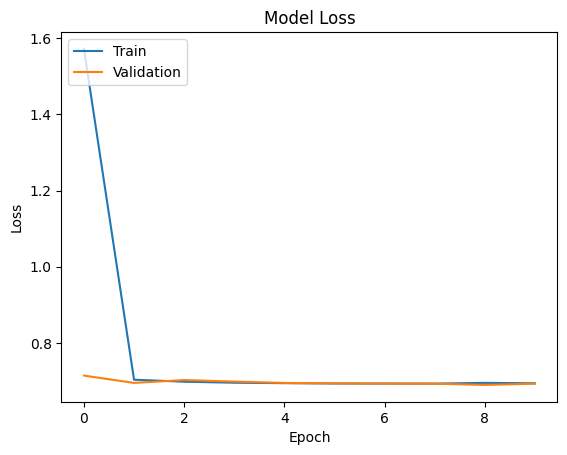

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd

# Generate predictions
predictions = model.predict(X_test)

# Save predictions and true labels
results = pd.DataFrame({'True Labels': y_test, 'Predictions': predictions.flatten()})
results.to_csv("/content/st_petersburg_cnn_project/results/predictions.csv", index=False)
print("Predictions saved successfully!")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predictions saved successfully!


In [ ]:
from wfdb import rdrecord, rdann

def load_data(record_name, data_path):
    """
    Load ECG data and annotations from the given record name.
    Args:
        record_name (str): Record name (e.g., 'I01').
        data_path (str): Path to the folder containing data files.
    Returns:
        tuple: ECG signals (numpy array) and annotations (labels).
    """
    record_path = f"{data_path}/{record_name}"
    record = rdrecord(record_path)  # Load ECG signals
    annotations = rdann(record_path, 'atr')  # Load annotations
    return record.p_signal, annotations.symbol


In [ ]:
data_path = "/content/st_petersburg_cnn_project/data"
record_name = "I01"  # Example record
signals, labels = load_data(record_name, data_path)

print(f"Signals Shape: {signals.shape}, Labels Count: {len(labels)}")


Signals Shape: (462600, 12), Labels Count: 2757


In [ ]:
def preprocess_data(signals):
    """
    Normalize ECG signals to the range [0, 1].
    Args:
        signals (numpy array): Raw ECG signals.
    Returns:
        numpy array: Normalized ECG signals.
    """
    return (signals - signals.min()) / (signals.max() - signals.min())

signals = preprocess_data(signals)


In [ ]:
def segment_data(signals, segment_length=1000):
    """
    Segment ECG signals into fixed-length chunks.
    Args:
        signals (numpy array): Normalized ECG signals.
        segment_length (int): Length of each segment.
    Returns:
        numpy array: Segmented signals.
    """
    X = []
    for i in range(0, len(signals) - segment_length, segment_length):
        X.append(signals[i:i+segment_length])
    return np.array(X)

X = segment_data(signals, segment_length=1000)


In [ ]:
from sklearn.model_selection import train_test_split

# Dummy labels (replace with real annotation-based labels)
y = np.random.randint(0, 2, len(X))  # Binary classification placeholder

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from cnn_model import create_cnn

input_shape = (X_train.shape[1], X_train.shape[2])  # (segment_length, num_features)
model = create_cnn(input_shape)

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.4836 - loss: 1.0722 - val_accuracy: 0.5376 - val_loss: 0.6910
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4775 - loss: 0.7115 - val_accuracy: 0.5161 - val_loss: 0.6918
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4773 - loss: 0.6926 - val_accuracy: 0.4839 - val_loss: 0.7036
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.4959 - loss: 0.6908 - val_accuracy: 0.4624 - val_loss: 0.6954
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5448 - loss: 0.6877 - val_accuracy: 0.4839 - val_loss: 0.6993
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5089 - loss: 0.6878 - val_accuracy: 0.5591 - val_loss: 0.6937
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5869 - loss: 0.6772 - val_accuracy: 0.4946 - val_loss: 0.6955
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.5713 - loss: 0.6790 - val_accuracy: 0.4194 - 

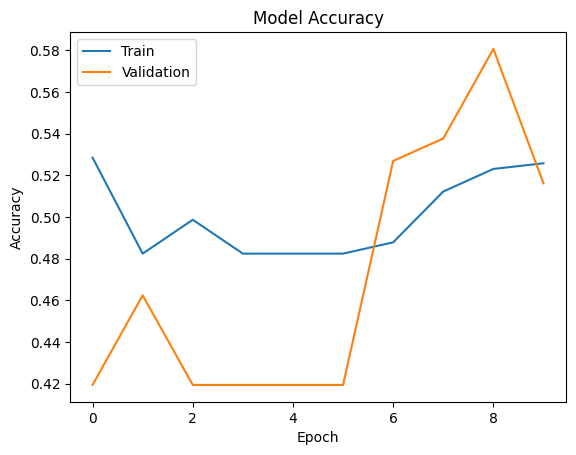

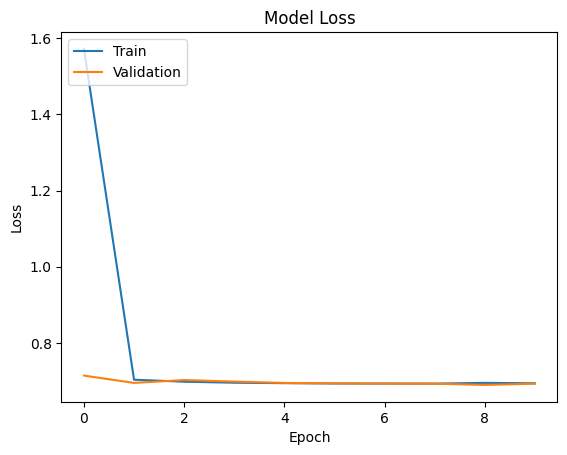

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import os
from wfdb import rdrecord, rdann

def load_all_data(data_path):
    """
    Load ECG signals and annotations from all records in the data folder.
    Args:
        data_path (str): Path to the folder containing data files.
    Returns:
        tuple: Combined ECG signals (list of numpy arrays) and labels.
    """
    all_signals = []
    all_labels = []

    # Iterate through all `.dat` files
    for file in os.listdir(data_path):
        if file.endswith('.dat'):  # Identify `.dat` files
            record_name = file.replace('.dat', '')  # Extract record name
            record_path = os.path.join(data_path, record_name)

            # Load signals and annotations
            record = rdrecord(record_path)
            annotations = rdann(record_path, 'atr')

            # Append signals and labels
            all_signals.append(record.p_signal)
            all_labels.append(annotations.symbol)

    return all_signals, all_labels

# Use the function to load data
data_path = "/content/st_petersburg_cnn_project/data"
all_signals, all_labels = load_all_data(data_path)

print(f"Loaded {len(all_signals)} records.")


Loaded 75 records.


In [ ]:
def normalize_signals(signals):
    """
    Normalize a list of signals to the range [0, 1].
    Args:
        signals (list of numpy arrays): Raw ECG signals.
    Returns:
        list of numpy arrays: Normalized ECG signals.
    """
    return [(signal - signal.min()) / (signal.max() - signal.min()) for signal in signals]

normalized_signals = normalize_signals(all_signals)


In [ ]:
def segment_all_signals(signals, segment_length=1000):
    """
    Segment a list of ECG signals into fixed-length chunks.
    Args:
        signals (list of numpy arrays): Normalized ECG signals.
        segment_length (int): Length of each segment.
    Returns:
        numpy array: Combined segmented signals.
    """
    X = []
    for signal in signals:
        for i in range(0, len(signal) - segment_length, segment_length):
            X.append(signal[i:i+segment_length])
    return np.array(X)

segment_length = 1000
X = segment_all_signals(normalized_signals, segment_length)

print(f"Segmented Data Shape: {X.shape}")


Segmented Data Shape: (34650, 1000, 12)


In [ ]:
import numpy as np

# Generate dummy labels (0 or 1) for each segment (replace with actual label logic)
y = np.random.randint(0, 2, X.shape[0])

print(f"Labels Shape: {y.shape}")


Labels Shape: (34650,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}, Testing Data Shape: {X_test.shape}")


In [ ]:
import os

# Create the project folder structure
folders = ['scripts', 'models', 'data']
for folder in folders:
    os.makedirs(folder, exist_ok=True)

print("Folder structure created.")


Folder structure created.


In [ ]:
with open('scripts/data_loader.py', 'w') as f:
    f.write("""
import os
import wfdb
import numpy as np

def load_signals(data_path):
    all_signals = []
    for file in os.listdir(data_path):
        if file.endswith('.dat'):
            record_name = file.replace('.dat', '')
            record_path = os.path.join(data_path, record_name)

            try:
                record = wfdb.rdrecord(record_path)
                all_signals.append(record.p_signal)
            except Exception as e:
                print(f"Error reading record {record_name}: {e}")
                continue
    return all_signals

def normalize_signals(signals):
    return [(signal - signal.min()) / (signal.max() - signal.min()) for signal in signals]

def segment_all_signals(signals, segment_length=1000):
    X = []
    for signal in signals:
        for i in range(0, len(signal) - segment_length, segment_length):
            X.append(signal[i:i + segment_length])
    return np.array(X)
    """)

print("data_loader.py created.")


data_loader.py created.


In [ ]:
with open('scripts/cnn_model.py', 'w') as f:
    f.write("""
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input

def create_cnn(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(16, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
    """)

print("cnn_model.py created.")


cnn_model.py created.


In [ ]:
with open('scripts/main.py', 'w') as f:
    f.write("""
from scripts.data_loader import load_signals, normalize_signals, segment_all_signals
from scripts.cnn_model import create_cnn
from sklearn.model_selection import train_test_split
import numpy as np

# Load signals
data_path = "data"
all_signals = load_signals(data_path)

# Normalize signals
normalized_signals = normalize_signals(all_signals)
print(f"Normalized {len(normalized_signals)} signals.")

# Segment signals
segment_length = 500
X = segment_all_signals(normalized_signals, segment_length)
print(f"Segmented Data Shape: {X.shape}")

# Generate dummy labels
y = np.random.randint(0, 2, len(X))
print(f"Labels Shape: {y.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train CNN
input_shape = (segment_length, X_train.shape[2])
model = create_cnn(input_shape)

history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

# Save model
model.save("models/cnn_model.h5")
print("Model saved.")
    """)

print("main.py created.")


main.py created.


In [ ]:
from google.colab import files
uploaded = files.upload()


KeyboardInterrupt: 

In [ ]:
%run scripts/main.py

ModuleNotFoundError: No module named 'wfdb'

In [ ]:
!pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.0 MB/s eta 0:00:00


In [ ]:
%run scripts/main.py

Exception: File `'scripts/main.py'` not found.

In [12]:
%run scripts/main.py

ImportError: cannot import name 'normalize_signals' from 'data_loader' (/content/scripts/data_loader.py)

In [9]:
!find . -name "*.pyc" -delete
